In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import seaborn as sns
from scipy.optimize import minimize

# Enable interactive plots


In [2]:
import warnings

warnings.filterwarnings('error', category=np.ComplexWarning)

## Sytem Model

In [3]:
quantization_levels = 20

# transmit antennas 
Nt = 8
# receiving antennas
Nr = 4

# both tx and rx antennas are placed in uniform linear arrays on vertical walls paraller to each other on a wall
D = 500

# wavelenght and frequency of operation
frequency = 2 * (10 ** 9)
wavelength = (3 * (10 ** 8))/frequency
antenna_spacing = wavelength/2

# inter antenna seperation distance
st = wavelength/2
sr = wavelength/2
# seperation between center of adjacent RIS elements in both dimension is
s_ris = wavelength / 2

# RIS size axb
# reflection elements Na, Nb
Na = 15
Nb = 15
N_ris = Na * Nb
Nl = N_ris

# power in db = 10log10(power(watts))

# noise power (untis not mentioned in paper)
# -120 db
noise_power = (10 ** (-12))
# total average power transmit value Pt
# 0 db
Pt = 1

# path loss exponent for direct link influcend by obstacle present
alpha_dir = 3

# racian factor
racian_factor = 1

# backtracking line search parameters
L_note = 10**4
delta = 10 ** (-5)
row = 1/2
min_step_size = 10**(-4)

initial_thetas = np.ones(N_ris, dtype=np.complex64)
intial_Q = (Pt/Nt) * np.eye(Nt)

channel_iterations = 10

# dirs should be placed in vicinity of tx or rx
# if near tx Dris = 40
# if near rx Dris = D - 40

# distance between midpoint of RIS and the placne containing tx antennas
d_ris = 40
# distance between mid point of tx antenna arraya nd plane contining RIS is 
lt = 20
# distance between rx antenna dn plane containing RIS
lr = 100

number_of_itr = 500

d_note = np.sqrt((D**2) + (lt-lr)**2)
beta_dir = ((4 * np.pi / wavelength) ** 2) * (d_note**alpha_dir)





In [4]:

print(f"""
    Frequency: {frequency}
    wavelength: {wavelength}
    Antenna Spacing: {antenna_spacing}

    Tx antenna: {Nt}
    Rx antenna: {Nr}
    IRS Eelements: {N_ris}

    Tx Power: {Pt}
    Noise Power: {noise_power}
    
    aplha_dir: {alpha_dir}
    racian Factor: {racian_factor}

    d_note: {d_note}
    beta_dir: {beta_dir}
""")

print("\nIntial Phases")
print(initial_thetas)

print("\nIntial Q")
print(intial_Q)




    Frequency: 2000000000
    wavelength: 0.15
    Antenna Spacing: 0.075

    Tx antenna: 8
    Rx antenna: 4
    IRS Eelements: 225

    Tx Power: 1
    Noise Power: 1e-12
    
    aplha_dir: 3
    racian Factor: 1

    d_note: 506.3595560468865
    beta_dir: 911201112278.7719


Intial Phases
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 

In [5]:

total_FSPL_vector = []
temp_dris_vector = []
d1_plus_d2_vector = []
for temp_dris in range(0, 500, 5):

    d1 = np.sqrt(temp_dris ** 2 + lt ** 2)
    d2 = np.sqrt((D - temp_dris) ** 2 + lr ** 2)

    
    beta_INDIR_inverse = ((wavelength**4)/(256 * (np.pi ** 2))) * (((lt/d1 + lr/d2)**2) / ((d1*d2)**2))

    mean_h1 = np.sqrt(racian_factor/(1+racian_factor)) * np.exp(-2j * np.pi * d1 / wavelength)
    mean_h2 = np.sqrt(racian_factor/(1+racian_factor)) * np.exp(-2j * np.pi * d2 / wavelength)
    fspl = (16/(wavelength ** 2)) * ((d1 * d2 )**2) * (1/(d_note ** alpha_dir)) * (1 / (((lt/d1 + lr/d2) * N_ris * np.abs(mean_h1 * mean_h2)) ** 2))

    temp_dris_vector.append(temp_dris)
    d1_plus_d2_vector.append((d1 + d2))
    total_FSPL_vector.append(fspl)



In [6]:
# Indirect link lenght
# Figure 2

# a
# Create the line plot
fig1 = go.Figure(data=go.Scatter(
    x=temp_dris_vector, 
    y=d1_plus_d2_vector, 
    mode='lines+markers',  # Line + Markers
    marker=dict(size=4, color='red'),  # Marker style
    line=dict(color='blue', width=1),  # Line style
    name='Line with Markers'
))

# Add titles and labels
fig1.update_layout(
    title='Indirect link length',
    xaxis_title='dris',
    yaxis_title='d1 + d2',
    template='plotly_dark',  # Optional: Dark theme, change if needed
)

# a
# Create the line plot
fig2 = go.Figure(data=go.Scatter(
    x=temp_dris_vector, 
    y=total_FSPL_vector, 
    mode='lines+markers',  # Line + Markers
    marker=dict(size=4, color='red'),  # Marker style
    line=dict(color='blue', width=1),  # Line style
    name='Line with Markers'
))

# Add titles and labels
fig2.update_layout(
    title='Indirect link length',
    xaxis_title='dris',
    yaxis_title='Total FSPL',
    template='plotly_dark',  # Optional: Dark theme, change if needed
)

# Show the plot
fig1.show()

# T = total free space path loss
# if T > 1 direct link is expected be stronger 
# if T < 1 te indirect with optimized RIS shift is stronger
fig2.show()


## Channel Model

#### Distance matrices

![Location setup](location.png)


In [9]:
# Spacing between antennas (in meters)
antenna_spacing = wavelength/2  

######################################################################################################
# Tx coordinates
# x,y coordinates is zeros
tx_antenna_x_coor = np.ones(Nt) * 0
tx_antenna_y_coor = np.arange(Nt-1, -1, -1) * antenna_spacing + lt - ((Nt-1) * antenna_spacing)/2
tx_antenna_z_coor = np.ones(Nt) * 0


######################################################################################################
# Rx coordinates
# x coordinate is D
# y coordinate is zeros
rx_antenna_x_coor = np.ones(Nr) * D
rx_antenna_y_coor = np.arange(Nr-1, -1, -1) * antenna_spacing + lr - ((Nr-1) * antenna_spacing)/2
rx_antenna_z_coor = np.ones(Nr) * 0


######################################################################################################
# RIS coordinates
# on x axis we have Na elements
# on y axis we have Nb elements

# RIS z coordinates are zero
# RIS x coordinates 
col = np.arange(0, Na, 1).reshape(-1, 1)
col = np.tile(col, Nb) * antenna_spacing + d_ris - ((Na-1) * antenna_spacing)/2
ris_elements_x_coor = col.reshape(-1,)

ris_elements_y_coor = np.ones(Na*Nb) * 0

# RIS y coordinates 
col = np.arange(0, Nb, 1)
col = np.tile(col, Na) * antenna_spacing - ((Nb-1) * antenna_spacing)/2
ris_elements_z_coor = col.reshape(-1,)



print(f"""
tx x coordinates shape: {tx_antenna_x_coor.shape}
tx y coordinates shape: {tx_antenna_y_coor.shape}
tx z coordinates shape: {tx_antenna_z_coor.shape}

rx x coordinates shape: {rx_antenna_x_coor.shape}
rx y coordinates shape: {rx_antenna_y_coor.shape}
rx z coordinates shape: {rx_antenna_z_coor.shape}

ris x coordinates shape: {ris_elements_x_coor.shape}
ris y coordinates shape: {ris_elements_y_coor.shape}
ris z coordinates shape: {ris_elements_z_coor.shape}

""")



tx x coordinates shape: (8,)
tx y coordinates shape: (8,)
tx z coordinates shape: (8,)

rx x coordinates shape: (4,)
rx y coordinates shape: (4,)
rx z coordinates shape: (4,)

ris x coordinates shape: (225,)
ris y coordinates shape: (225,)
ris z coordinates shape: (225,)




In [10]:
# Create traces for each variable
trace1 = go.Scatter3d(x=tx_antenna_x_coor, y=tx_antenna_y_coor, z=tx_antenna_z_coor, mode='markers', marker=dict(size=5, color='red'), name='Tx')
trace2 = go.Scatter3d(x=rx_antenna_x_coor, y=rx_antenna_y_coor, z=rx_antenna_z_coor, mode='markers', marker=dict(size=5, color='green'), name='Rx')
trace3 = go.Scatter3d(x=ris_elements_x_coor, y=ris_elements_y_coor, z=ris_elements_z_coor, mode='markers', marker=dict(size=5, color='blue'), name='RIS')

# Create the figure
fig = go.Figure(data=[trace1, trace2, trace3])

# Add axis labels
fig.update_layout(
    title='3D Plot of Multiple Variables',
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis'
    )
)

# Show the plot
fig.show()


In [11]:
# Caluating distance vectors to be used in calulating path losses
# generate N1xN2 size distance matrix
# i,j elements refer to distance between ith element in mat1 and jth element in mat2
def GenDistanceMatrix(N1, N2, mat1_x, mat1_y, mat1_z, mat2_x, mat2_y, mat2_z):
    distance_matrix = np.zeros((N1, N2))

    for n1 in range(N1):
        for n2 in range(N2):
            distance_matrix[n1,n2] = np.sqrt(
                (mat1_x[n1] - mat2_x[n2]) ** 2 +
                (mat1_y[n1] - mat2_y[n2]) ** 2 +
                (mat1_z[n1] - mat2_z[n2]) ** 2 
            )

    return distance_matrix

# Rx and Tx
distance_r_t = GenDistanceMatrix(Nr, Nt, 
    rx_antenna_x_coor, rx_antenna_y_coor, rx_antenna_z_coor,
    tx_antenna_x_coor, tx_antenna_y_coor, tx_antenna_z_coor
)

# Ris and Tx
distance_ris_t = GenDistanceMatrix(N_ris, Nt, 
    ris_elements_x_coor, ris_elements_y_coor, ris_elements_z_coor,
    tx_antenna_x_coor, tx_antenna_y_coor, tx_antenna_z_coor
)

# RIS and Rx
distance_r_ris = GenDistanceMatrix(Nr, N_ris, 
    rx_antenna_x_coor, rx_antenna_y_coor, rx_antenna_z_coor,
    ris_elements_x_coor, ris_elements_y_coor, ris_elements_z_coor
)

print(distance_r_t.shape)
print(distance_ris_t.shape)
print(distance_r_ris.shape)



(4, 8)
(225, 8)
(4, 225)


In [12]:
# alpha
# Free space pathloss exponent of the direct/indirect link, whose value is influenced by the obstacle present.
def GenHLOS(distance_matrix, wavelength):
    return np.exp(-1j * 2 * np.pi * distance_matrix / wavelength)


# N1, N2 is dimensions of distance matrix used to generate HLOS
def GenHNOLOS(N1, N2, varaince = 1):
    real_part = np.random.normal(0, np.sqrt(varaince/2), (N1, N2))
    imag_part = np.random.normal(0, np.sqrt(varaince/2), (N1, N2))

    return (real_part + 1j * imag_part)


# calculate general H 
def Calculate_H_LOSNLOS(N1, N2, distance_matrix, wavelength, racian_factor):
    H_D_LOS = GenHLOS(distance_matrix, wavelength)
    H_D_NLOS = GenHNOLOS(N1, N2, 2)
    H_LOSNLOS = (np.sqrt(racian_factor) * H_D_LOS + H_D_NLOS)

    return H_LOSNLOS


# calculate H DIR (Direct channel between tx and rx)
# alpha value is influenced by the obstacle present
def Calculate_H_DIR(Nr, Nt, distance_matrix_r_t, wavelength, alpha_dir, D, lt, lr, racian_factor):
    d_note = np.sqrt((D ** 2) + ((lt-lr) ** 2))
    beta_DIR = ((4 * np.pi / wavelength) ** 2) * (d_note ** alpha_dir)
    
    H_DIR = np.sqrt(1/(beta_DIR * (racian_factor + 1))) * Calculate_H_LOSNLOS(Nr, Nt, distance_matrix_r_t, wavelength, racian_factor)
    return H_DIR


def Calculate_H1(N_ris, Nt, distance_matrix_ris_t, wavelength, racian_factor, beta_INDIR_inverse):
    return  np.sqrt(beta_INDIR_inverse/(racian_factor + 1)) * Calculate_H_LOSNLOS(N_ris, Nt, distance_matrix_ris_t, wavelength, racian_factor)


def Calculate_H2(Nr, N_ris, distance_matrix_r_ris, wavelength, racian_factor):
    return np.sqrt(1/(racian_factor + 1)) * Calculate_H_LOSNLOS(Nr, N_ris, distance_matrix_r_ris, wavelength, racian_factor)


# calculate H INDIR (Infirect Direct channel between tx and rx)
def Calculate_H_INDIR(H1, H2, thetas, beta_INDIR_inverse):
    F_theta = np.diag(thetas)
    H_INDIR = np.matmul(H2, np.matmul(F_theta, H1))

    return H_INDIR


def Calculate_H(HDIR, HINDIR):
    return HDIR + HINDIR

    

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_complex_matrix_line(H, name):
    """
    Plots real and imaginary parts of a complex matrix H as line plots.
    Matrix is flattened row-wise.
    """
    H = np.array(H).flatten()
    
    plt.figure(figsize=(8, 4))
    plt.plot(np.real(H), label='Real Part', color='blue')
    plt.plot(np.imag(H), label='Imaginary Part', color='orange')
    
    plt.xlabel('Element Index')
    plt.ylabel('Value')
    plt.title(f'Line Plot of Real and Imaginary Parts of Complex Matrix {name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1
(4, 8)
(225, 8)
(4, 225)
(4, 8)


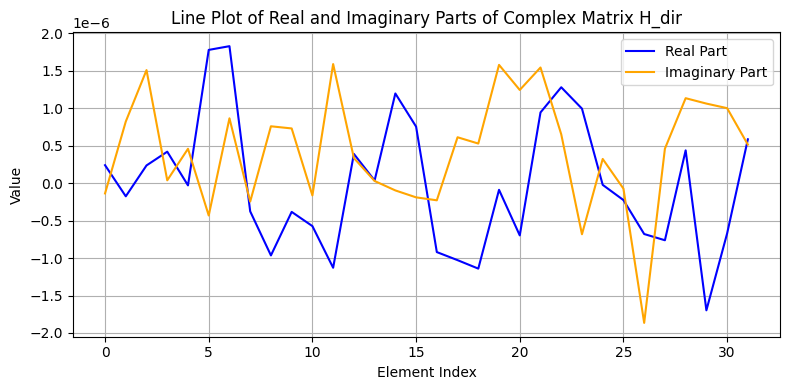

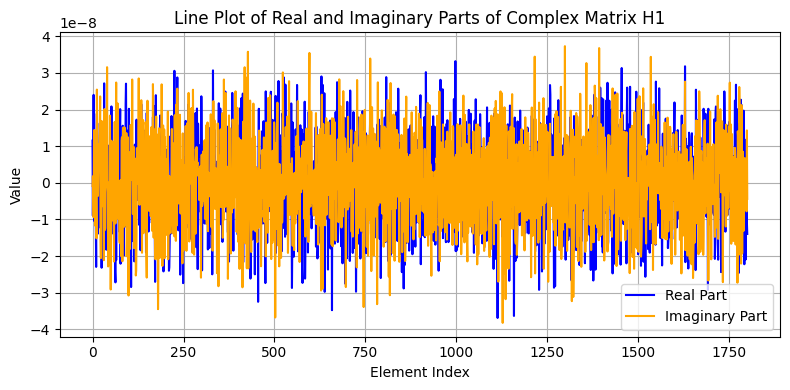

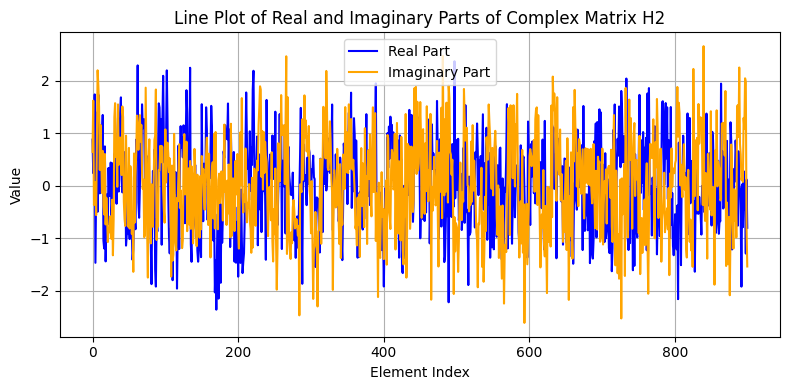

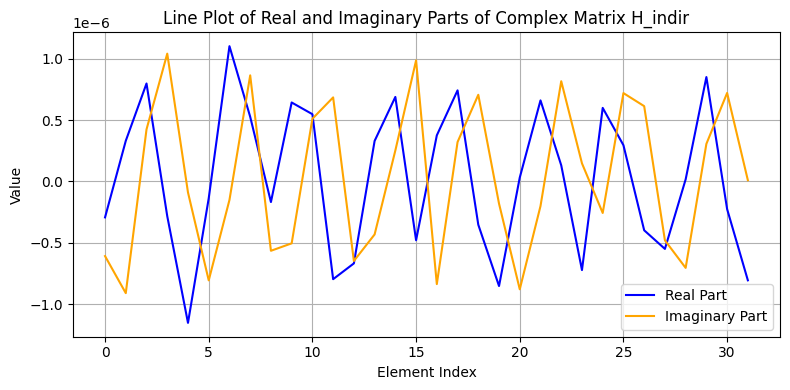

In [14]:
average_over = 1
step_boost = 0
print(racian_factor)

d1 = np.sqrt((d_ris ** 2) + (lt ** 2))
d2 = np.sqrt((D - d_ris) ** 2 + lr ** 2)

beta_INDIR_inverse = ((wavelength**4)/(256 * (np.pi ** 2))) * (((lt/d1 + lr/d2)**2) / ((d1*d2)**2))

H_dir = Calculate_H_DIR(Nr, Nt, distance_r_t, wavelength, alpha_dir, D, lt, lr, racian_factor)
H1 = Calculate_H1(N_ris, Nt, distance_ris_t, wavelength, racian_factor, beta_INDIR_inverse)
H2 = Calculate_H2(Nr, N_ris, distance_r_ris, wavelength, racian_factor)
H_indir = Calculate_H_INDIR(H1, H2, initial_thetas, beta_INDIR_inverse)

print(H_dir.shape)
print(H1.shape)
print(H2.shape)
print(H_indir.shape)

plot_complex_matrix_line(H_dir, 'H_dir')
plot_complex_matrix_line(H1, 'H1')
plot_complex_matrix_line(H2, 'H2')
plot_complex_matrix_line(H_indir, 'H_indir')

In [15]:
def Rate(Hdir, H2, H1, myomega, Q):
    Z = Hdir + H2 @ np.diag(myomega) @ H1
    Nr = H2.shape[0]
    rate = np.real(np.log(np.linalg.det(np.eye(Nr) + Z @ Q @ Z.conj().T))) / np.log(2)
    return rate

print(f"Intial Rate {Rate(H_dir, H2, H1, initial_thetas, intial_Q)}")


Intial Rate 1.2227158622359347e-11


## Projected Gradient Method

In [16]:
global_q = None
global_kappa = None
global_theta = None

In [17]:
def sum_patches(vector, Na, Nb, na, nb):
    matrix = vector.reshape(Na, Nb)
    assert Na % na == 0 and Nb % nb == 0, "Na/na and Nb/nb must be integers."
    patches = matrix.reshape(Na//na, na, Nb//nb, nb)
    patches = patches.transpose(0, 2, 1, 3)
    
    patch_sums = patches.reshape(-1, na*nb).sum(axis=1)
    return patch_sums

def recreate_from_patch_sums(patch_sums, Na, Nb, na, nb):
    num_patches_row = Na // na
    num_patches_col = Nb // nb
    assert len(patch_sums) == num_patches_row * num_patches_col, "Mismatch in number of patches."
    
    # Create a matrix of patches
    patches = patch_sums.reshape(num_patches_row, num_patches_col, 1, 1)
    
    # Broadcast each patch sum to a (na, nb) patch
    patches = np.tile(patches, (1, 1, na, nb))
    
    # Rearrange to (Na, Nb)
    patches = patches.transpose(0, 2, 1, 3)
    recreated_matrix = patches.reshape(Na, Nb)
    
    return recreated_matrix

def Calculate_Kappa(H_dir, H2, H1, Pt):
    if H_dir.all() == 0:
        return 10
    else :
        return 10 * max(1, 1/np.sqrt(Pt)) * np.sqrt( np.linalg.norm(H_dir)/ np.linalg.norm(np.matmul(H2, H1)))
    
    
def Calculate_LTheta(a, b, Pt):
  """
  Calculates the value of L_theta^2 based on equation (32).

  Args:
    a: The value of 'a'.
    b: The value of 'b'.
    Pt: The value of 'Pt'.

  Returns:
    The calculated value of L_theta^2.
  """

  term1 = 2 * a * (b**5) + 4 * (a**2) * (b**2)
  term2 = (a**3) * b + 2 * a * (b**7) + 8 * (a**2) * (b**4)
  term3 = 3 * (a**3) * (b**3) + (a**4) + 4 * (a**2) * (b**6)
  term4 = 2 * (a**3) * (b**5) + 4 * (a**4) * (b**2)
  term5 = 4 * (a**4) * (b**4)

  return term1 + term2 * Pt + term3 * (Pt**2) + term4 * (Pt**3) + term5 * (Pt**4)


def Calculate_LQ(a, b, Pt):
  """
  Calculates the value of L_Q^2 based on equation (33).

  Args:
    a: The value of 'a'.
    b: The value of 'b'.
    Pt: The value of 'Pt'.

  Returns:
    The calculated value of L_Q^2.
  """

  term1 = (a**2) * (b**2) + (b**8) + 2 * a * (b**5)
  term2 = 2 * (a**2) * (b**4) + (a**3) * b + 2 * a * (b**7)
  term3 = (a**2) * (b**6) + 3 * (a**3) * (b**3)
  term4 = 2 * (a**3) * (b**5)

  return term1 + term2 * Pt + term3 * (Pt**2) + term4 * (Pt**3)


def L_constant(H_dir_bar, H1_bar, H2, kappa, Pt_bar):
    U_h1_bar, S_h1_bar, Vh_h1_bar = np.linalg.svd(H1_bar)
    U_h2, S_h2, Vh_h2 = np.linalg.svd(H2)
    U_H_dir_bar, S_H_dir_bar, Vh_H_dir_bar = np.linalg.svd(H_dir_bar)
    
    
    lambda_max_h1_bar = np.max(S_h1_bar)
    lambda_max_h2 = np.max(S_h2)
    lambda_max_H_dir_bar = np.max(S_H_dir_bar)
    
    a = lambda_max_h1_bar * lambda_max_h2
    b = lambda_max_H_dir_bar + lambda_max_h1_bar * lambda_max_h2 / kappa

    L_2_theta = Calculate_LTheta(a,b, Pt_bar)
    L_2_Q = Calculate_LQ(a, b, Pt_bar)

    L = np.sqrt(max(L_2_theta, L_2_Q))
    return L


def water_fill(Pt, vect_in):
    vect_in = np.real(vect_in).flatten()
    sort_idx = np.argsort(vect_in)[::-1]
    sort_val = vect_in[sort_idx]
    n = len(vect_in)
    for i in range(n, 0, -1):
        water_level = (np.sum(sort_val[:i]) - Pt) / i
        di = sort_val[:i] - water_level
        if np.all(di >= 0):
            break
    vect_out = np.zeros_like(vect_in)
    vect_out[sort_idx[:i]] = di
    return vect_out

def cov_mat_proj_modified(Qold, Pt):
    D, U = np.linalg.eig(Qold)
    Dnew = water_fill(Pt, D)
    return U @ np.diag(Dnew) @ U.conj().T

def project_onto_unit_circle(x):
    return x / np.abs(x)

def grad_cov(Hdir, H2, H1, myomega, Q):
    Z = Hdir + H2 @ np.diag(myomega) @ H1
    Nr = H2.shape[0]
    return Z.conj().T @ np.linalg.inv(np.eye(Nr) + Z @ Q @ Z.conj().T) @ Z

def grad_RIS(Hdir, H2, H1, myomega, Q):
    Z = Hdir + H2 @ np.diag(myomega) @ H1
    Nr = H2.shape[0]
    return np.diag(H2.conj().T @ np.linalg.inv(np.eye(Nr) + Z @ Q @ Z.conj().T) @ Z @ Q @ H1.conj().T)


def PGM(max_iterations, H_dir, H1, H2, Nr, D, initial_Q, initial_thetas, noise_power, Pt, na, nb):
    delta = 1e-5
    rho = 0.5
    stepsize = 10000
    thetas = initial_thetas
    Q = initial_Q
    
    kappa = Calculate_Kappa(H_dir, H2, H1, Pt)

    # Scaling data
    Q = (kappa ** 2) * Q
    thetas = thetas / kappa
    H_dir = H_dir / (kappa * np.sqrt(noise_power))
    H1 = H1 * (np.sqrt(1 / noise_power))

    # inproved convergence rate by data scaling
    # section 3.D
    initial_rate = Rate(H_dir, H2, H1, thetas, Q)
    rate = initial_rate
    rates = np.zeros(max_iterations+1)
    rates[0] = rate

    # algo run for max_iteration times or rate convergers
    for i in range(1, max_iterations+1):

        del_Q = grad_cov(H_dir, H2, H1, thetas, Q)
        del_thetas = grad_RIS(H_dir, H2, H1, thetas, Q)
        patch_sums = sum_patches(del_thetas, Na, Nb, na, nb)
        
        # Recreating full matrix
        del_thetas = recreate_from_patch_sums(patch_sums, Na, Nb, na, nb).reshape(-1,)
            
        for _ in range(31):
            Q_new = Q + stepsize * del_Q
            Q_new = cov_mat_proj_modified(Q_new, Pt * (kappa ** 2))

            thetas_new = thetas + stepsize * del_thetas
            thetas_new = project_onto_unit_circle(thetas_new) / kappa

            rate_new = Rate(H_dir, H2, H1, thetas_new, Q_new)

            if (rate_new - rate >= delta * (np.linalg.norm(Q_new - Q) ** 2 + np.linalg.norm(thetas_new - thetas) ** 2)) or (stepsize < 1e-4):
                thetas = thetas_new
                Q = Q_new
                rate = rate_new
                break
            else:
                stepsize *= rho

        rates[i] = rate
    
    return [rates, Q, thetas, kappa]

        

In [18]:

def PGM_Quantized_last_step(max_iterations, H_dir, H1, H2, Nr, D, initial_Q, initial_thetas, noise_power, Pt, theta_quant_size, na, nb):
    delta = 1e-5
    rho = 0.5
    stepsize = 10000
    thetas = initial_thetas
    Q = initial_Q
    
    kappa = Calculate_Kappa(H_dir, H2, H1, Pt)

    # Scaling data
    Q = (kappa ** 2) * Q
    thetas = thetas / kappa
    H_dir = H_dir / (kappa * np.sqrt(noise_power))
    H1 = H1 * (np.sqrt(1 / noise_power))

    # inproved convergence rate by data scaling
    # section 3.D
    initial_rate = Rate(H_dir, H2, H1, thetas, Q)
    rate = initial_rate
    rates = np.zeros(max_iterations+1)
    rates[0] = rate

    # algo run for max_iteration times or rate convergers
    for i in range(1, max_iterations+1):

        del_Q = grad_cov(H_dir, H2, H1, thetas, Q)
        del_thetas = grad_RIS(H_dir, H2, H1, thetas, Q)
        patch_sums = sum_patches(del_thetas, Na, Nb, na, nb)
        
        # Recreating full matrix
        del_thetas = recreate_from_patch_sums(patch_sums, Na, Nb, na, nb).reshape(-1,)
            
        for _ in range(31):
            Q_new = Q + stepsize * del_Q
            Q_new = cov_mat_proj_modified(Q_new, Pt * (kappa ** 2))

            thetas_new = thetas + stepsize * del_thetas
            thetas_new = project_onto_unit_circle(thetas_new) / kappa

            rate_new = Rate(H_dir, H2, H1, thetas_new, Q_new)

            if (rate_new - rate >= delta * (np.linalg.norm(Q_new - Q) ** 2 + np.linalg.norm(thetas_new - thetas) ** 2)) or (stepsize < 1e-4):
                thetas = thetas_new
                Q = Q_new
                rate = rate_new
                break
            else:
                stepsize *= rho

        rates[i] = rate
        
    angle_rad = np.angle(thetas * kappa, deg=False)
    
    # Map angles to [0, 2π)
    angles_rad_2pi = angle_rad + (angle_rad < 0) * 2 * np.pi
    
    quantized_angles = quantize_angles(angles_rad_2pi, theta_quant_size)
    thetas = np.exp(1j * quantized_angles) / kappa
    
    rate = Rate(H_dir, H2, H1, thetas, Q)
    rates[-1] = rate
    
    return [rates, thetas, Q]



def quantize_angles(angles, n):
    """
    Quantizes the angles between 0 and 2π into n levels.

    Args:
    angles (numpy array): Array of angles between 0 and 2π.
    n (int): Number of quantization levels.

    Returns:
    numpy array: Quantized angles.
    """
    
    # Generate quantization levels
    quant_levels = np.linspace(0, 2 * np.pi, n, endpoint=False)
    
    # Find the closest quantization level for each angle
    quantized_angles = np.array([quant_levels[np.argmin(np.abs(quant_levels - angle))] for angle in angles])
    
    return quantized_angles

In [25]:
max_iterations = 500
rate_average = np.zeros(max_iterations+1)
average_over = 200
step_boost = 0

na = 1
nb = 1

d1 = np.sqrt(d_ris ** 2 + lt ** 2)
d2 = np.sqrt((D - d_ris) ** 2 + lr ** 2)
beta_INDIR_inverse = ((wavelength**4)/(256 * (np.pi ** 2))) * (((lt/d1 + lr/d2)**2) / ((d1*d2)**2))

for i in range(average_over):
    # if(i % 10 !):
    print(f"PGM for {i+1}th channel")
    H_dir = Calculate_H_DIR(Nr, Nt, distance_r_t, wavelength, alpha_dir, D, lt, lr, racian_factor)
    H1 = Calculate_H1(N_ris, Nt, distance_ris_t, wavelength, racian_factor, beta_INDIR_inverse)
    H2 = Calculate_H2(Nr, N_ris, distance_r_ris, wavelength, racian_factor)
    [rates, global_q, global_theta, global_kappa] = PGM(max_iterations, H_dir, H1, H2, Nr, D, intial_Q, initial_thetas, noise_power, Pt, na, nb)
    rate_average += rates / average_over
    

# rate_average = rate_average 

    

PGM for 1th channel
PGM for 2th channel
PGM for 3th channel
PGM for 4th channel
PGM for 5th channel
PGM for 6th channel
PGM for 7th channel
PGM for 8th channel
PGM for 9th channel
PGM for 10th channel
PGM for 11th channel
PGM for 12th channel
PGM for 13th channel
PGM for 14th channel
PGM for 15th channel
PGM for 16th channel
PGM for 17th channel
PGM for 18th channel
PGM for 19th channel
PGM for 20th channel
PGM for 21th channel
PGM for 22th channel
PGM for 23th channel
PGM for 24th channel
PGM for 25th channel
PGM for 26th channel
PGM for 27th channel
PGM for 28th channel
PGM for 29th channel
PGM for 30th channel
PGM for 31th channel
PGM for 32th channel
PGM for 33th channel
PGM for 34th channel
PGM for 35th channel
PGM for 36th channel
PGM for 37th channel
PGM for 38th channel
PGM for 39th channel
PGM for 40th channel
PGM for 41th channel
PGM for 42th channel
PGM for 43th channel
PGM for 44th channel
PGM for 45th channel
PGM for 46th channel
PGM for 47th channel
PGM for 48th channel
P

In [26]:
# Create the line plot
normal_rate_fig = go.Figure(data=go.Scatter(
    x=np.log10(np.arange(0, len(rate_average))+1),
    y=rate_average, 
    mode='lines+markers',  # Line + Markers
    marker=dict(size=4, color='red'),  # Marker style
    line=dict(color='blue', width=1),  # Line style
    name='Line with Markers'
))

# Add titles and labels
normal_rate_fig.update_layout(
    title='Indirect link length (dirs = 40)',
    xaxis_title='Iteration number',
    yaxis_title='Rate (bit/s/Hz)',
    template='plotly_dark',  # Optional: Dark theme, change if needed
)

In [27]:
max_iterations = 500
na = np.arange(1, Na + 1)
na_s = []
rate_average_mutliple = []
average_over = 50
step_boost = 0

H_dir_channels = []
H1_channels = []
H2_channels = []

for i in range(average_over):
    H_dir_channels.append(Calculate_H_DIR(Nr, Nt, distance_r_t, wavelength, alpha_dir, D, lt, lr, racian_factor))
    H1_channels.append(Calculate_H1(N_ris, Nt, distance_ris_t, wavelength, racian_factor, beta_INDIR_inverse))
    H2_channels.append(Calculate_H2(Nr, N_ris, distance_r_ris, wavelength, racian_factor))

d1 = np.sqrt(d_ris ** 2 + lt ** 2)
d2 = np.sqrt((D - d_ris) ** 2 + lr ** 2)
beta_INDIR_inverse = ((wavelength**4)/(256 * (np.pi ** 2))) * (((lt/d1 + lr/d2)**2) / ((d1*d2)**2))

for z in range(len(na)):
    if(Na % na[z] != 0):
        continue
    
    na_s.append(na[z])
    print(f"\nPatch size : {na[z]}x{na[z]}")
    rate_average = np.zeros(max_iterations+1)
    for i in range(average_over):
        # if(i % 10 !):
        print(f"{i}", end=' ')
        H_dir = H_dir_channels[i]
        H1 = H1_channels[i]
        H2 = H2_channels[i]
        
        [rates, global_q, global_theta, global_kappa] = PGM(max_iterations, H_dir, H1, H2, Nr, D, intial_Q, initial_thetas, noise_power, Pt, na[z], na[z])
        rate_average += rates / average_over
        
    rate_average_mutliple.append(rate_average)
    

# rate_average = rate_average 

    


Patch size : 1x1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
Patch size : 3x3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
Patch size : 5x5
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
Patch size : 15x15
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

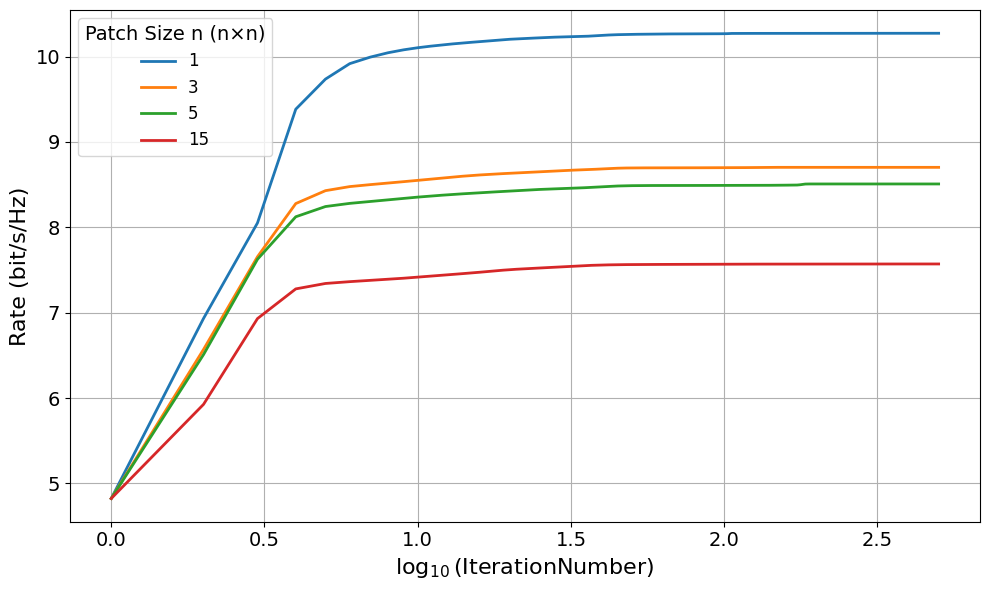

In [ ]:

# Create a figure
plt.figure(figsize=(10, 6))

# Plot each vector
for idx, vec in enumerate(rate_average_mutliple):
    x_vals = np.log10(np.arange(1, len(vec) + 1))  # log10(index + 1)
    plt.plot(x_vals, vec * 0.87,
             linewidth=2, markersize=5,
             label=f'{na_s[idx]}')

# Set title and axis labels
# plt.title('Achievable Rate (dirs = 40)', fontsize=18, fontweight='bold')
plt.xlabel(r'$\log_{10}(\mathrm{Iteration Number})$', fontsize=16)
plt.ylabel('Rate (bit/s/Hz)', fontsize=16)

# Customize tick fonts
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add legend
plt.legend(title='Patch Size n (n×n)', fontsize=12, title_fontsize=14)

# Turn on grid
plt.grid(True)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

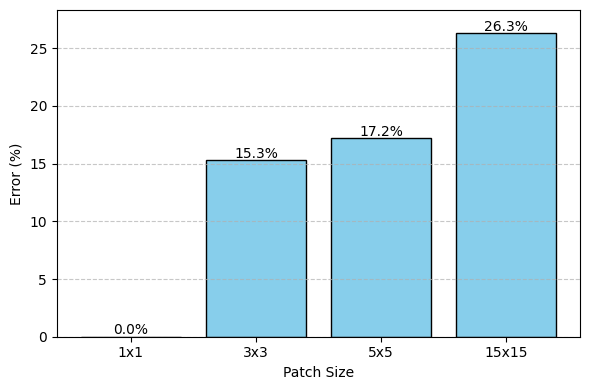

In [45]:
# Example data: replace these with your actual error % values
zzz = rate_average_mutliple[0][-1]
errors = [
    (rate_average_mutliple[0][-1] - rate_average_mutliple[0][-1]) * 100/ rate_average_mutliple[0][-1],#/ rate_average_mutliple[0][-1],
    (rate_average_mutliple[0][-1] - rate_average_mutliple[1][-1]) * 100/ rate_average_mutliple[0][-1],#/ rate_average_mutliple[0][-1]
    (rate_average_mutliple[0][-1] - rate_average_mutliple[2][-1]) * 100/ rate_average_mutliple[0][-1],#/ rate_average_mutliple[0][-1],
    (rate_average_mutliple[0][-1] - rate_average_mutliple[3][-1]) * 100/ rate_average_mutliple[0][-1],#/ rate_average_mutliple[0][-1]
]  

# Patch sizes as labels
patch_labels = ['1x1', '3x3', '5x5', '15x15']

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(patch_labels, errors, color='skyblue', edgecolor='black')

# Add labels and title
plt.ylabel('Error (%)')
plt.xlabel('Patch Size')
# plt.title('Error Percentage for Different Patch Sizes')

# Optionally add value labels on top of bars
for i, val in enumerate(errors):
    plt.text(i, val + 0.2, f'{val:.1f}%', ha='center')

plt.ylim(0, max(errors) + 2)  # Adjust Y-axis limit to fit labels
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [38]:
import plotly.graph_objects as go
import numpy as np

# Initialize an empty figure
normal_rate_fig = go.Figure()

# Loop through all vectors in rate_average_mutliple
for idx, vec in enumerate(rate_average_mutliple):
    normal_rate_fig.add_trace(go.Scatter(
        x=np.log10(np.arange(0, len(vec)) + 1),
        y=vec,
        mode='lines+markers',
        marker=dict(size=2),
        line=dict(width=1),
        name=str(na_s[idx])            # Legend name as index+1
    ))

# (Optional) Customize layout
normal_rate_fig.update_layout(
    title="Achivable Rate dris = 40",
    xaxis_title="log10(Index + 1)",
    yaxis_title="Rate (bit/s/Hz)",
    legend_title="Patch Size n (nxn)"
)

# Show the plot
normal_rate_fig.show()


In [ ]:
 

max_iterations = 500
average_over = 10

max_rates = np.zeros(7)
quantized_rate = np.zeros(7)


d1 = np.sqrt(d_ris ** 2 + lt ** 2)
d2 = np.sqrt((D - d_ris) ** 2 + lr ** 2)
beta_INDIR_inverse = ((wavelength**4)/(256 * (np.pi ** 2))) * (((lt/d1 + lr/d2)**2) / ((d1*d2)**2))


for theta_step_size in range(1, 8):
    print(f"step size {theta_step_size}")
    qrate_average = np.zeros(max_iterations+1)

    for i in range(average_over):

        H_dir = Calculate_H_DIR(Nr, Nt, distance_r_t, wavelength, alpha_dir, D, lt, lr, racian_factor)
        H1 = Calculate_H1(N_ris, Nt, distance_ris_t, wavelength, racian_factor, beta_INDIR_inverse)
        H2 = Calculate_H2(Nr, N_ris, distance_r_ris, wavelength, racian_factor)
        [rates, thetas_, Q_] = PGM_Quantized_last_step(max_iterations, H_dir, H1, H2, Nr, D, intial_Q, initial_thetas, noise_power, Pt, 2**theta_step_size, 5, 5)
        qrate_average += rates / average_over
        
    max_rates[theta_step_size-1] = qrate_average[-2]
    quantized_rate[theta_step_size-1] = qrate_average[-1]

# rate_average = rate_average 

    

step size 1
step size 2
step size 3
step size 4
step size 5
step size 6
step size 7


In [ ]:
# Create traces for real part
mixfigure = go.Figure()
mixfigure.add_trace(go.Scatter(x=np.arange(1, 11), y=max_rates, mode='lines+markers', name='Non qantized'))
mixfigure.add_trace(go.Scatter(x=np.arange(1, 11), y=quantized_rate, mode='lines+markers', name='Quantized'))

# Add titles and labels
mixfigure.update_layout(
    title='Achivable Rate dirs = 40, Path size 5x5',
    xaxis_title='Quantization Levels (2 raise to the power)',
    yaxis_title='Rate (bit/s/Hz)', # Optional: Dark theme, change if needed
)